# Setup

In [3]:
# Figure 3.1.1 — Sensors on x-axis; approaches in legend (bottom).
# Bars show deviation from manufacturer = values_pct - 100.
# On-bar labels are wrapped in two lines and automatically de-overlapped at the top.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
import os

# ------------------------------------------------------------
# Output
# ------------------------------------------------------------

BASE_DIR= r"C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/"
OUT_DIR = os.path.join(BASE_DIR,"v_calibration_output")


# ------------------------------------------------------------
# Data
# ------------------------------------------------------------
ALL_APPROACHES = [
    "Manufacturer 2012-13",
    "CREST single alternating Jul 18",
    "CREST single alternating Aug 18",
    "multiple simultaneous (vertical) Dec 18",
    "CREST single alternating Nov 19",
]

# Drop Nov 19 as requested
approaches = [
    "CREST single alternating Jul 18",
    "CREST single alternating Aug 18",
    "multiple simultaneous (vertical) Dec 18",
    "CREST single alternating Nov 19",
]

sensors = [
    "KZ CMP21 n18 (Class A, temp-corr)",
    "KZ CMP11 n12 (Class A)", # type 1 ?
    "KZ CMP11 n13 (Class A)",
]

# Sensitivities in %
values_all = pd.DataFrame(
    [
        [100.00, 0.00,   99.59,  99.92,  99.98],   # n18
        [100.00, 100.22, 100.22, 101.15, 100.46],  # n12
        [100.00, 100.60, 100.45, 101.21, 100.57],  # n13
    ],
    index=sensors, columns=ALL_APPROACHES
)

# Uncertainties in %
unc_all = pd.DataFrame(
    [
        [1.44,  np.nan, 1.52, 1.59, 1.54],  # n18 (Jul-18 uncertainty not provided)
        [1.44,  1.52,   1.52, 1.59, 1.54],  # n12
        [1.44,  1.52,   1.52, 1.59, 1.54],  # n13
    ],
    index=sensors, columns=ALL_APPROACHES
)

# Execution

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/v_calibration_output\\Figure_3_1_1_sensitivity_deviation.png'

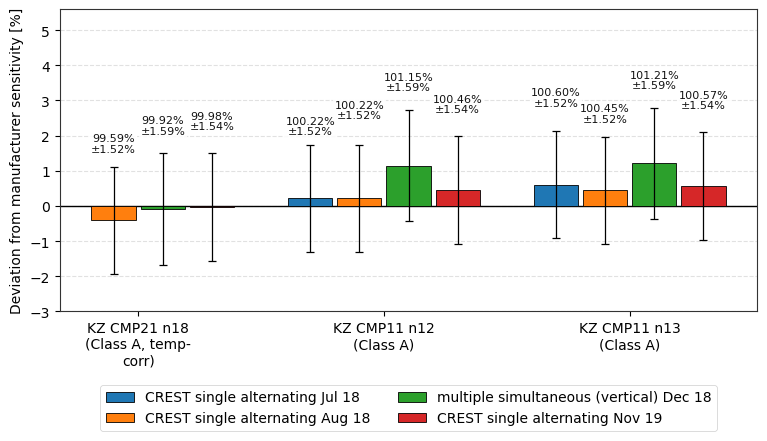

In [4]:

# Subset to the four approaches
values_pct = values_all[approaches].copy()
unc_pct    = unc_all[approaches].copy()

# Treat CMP21 n18 @ Jul-18 = 0.00% as missing (do not plot)
values_pct.loc["KZ CMP21 n18 (Class A, temp-corr)", "CREST single alternating Jul 18"] = np.nan

# Deviation to plot (y-axis)
dev_pct = values_pct - 100.0

# ------------------------------------------------------------
# Plot styling
# ------------------------------------------------------------
plt.rcParams.update({
    "axes.edgecolor": "#333",
    "axes.linewidth": 0.8,
    "grid.color": "#bdbdbd",
    "grid.linestyle": "--",
    "grid.alpha": 0.45,
    "axes.grid": True,
    "font.size": 10,
})

colors = plt.get_cmap('tab10').colors
fig, ax = plt.subplots(figsize=(9.0, 5.4))

# ------------------------------------------------------------
# Sensors on x-axis; approaches as grouped bars
# ------------------------------------------------------------
x = np.arange(len(sensors))
m = len(approaches)
bar_w = min(0.8 / m, 0.18)   # group width control
group_pad = 0.02

# Label placement knobs
LABEL_FSIZE  = 8            # smaller text as requested
LABEL_DY     = 0.25         # base offset above (bar + error) in percentage points
STAGGER_DY   = 0.12         # minimal extra spacing per approach within a group
BBOX_STYLE   = dict(facecolor="white", edgecolor="none", alpha=0.85, pad=1.0)

# collect Text objects per sensor group to de-overlap afterwards
labels_by_sensor = {i: [] for i in range(len(sensors))}

for j, appr in enumerate(approaches):
    offs = (j - (m-1)/2) * (bar_w + group_pad)
    y    = dev_pct[appr].values
    yerr = unc_pct[appr].values
    col  = colors[j % len(colors)]

    # Bars
    bars = ax.bar(x + offs, y, width=bar_w,
                  label=appr, color=col, edgecolor="black", linewidth=0.6, zorder=3)

    # Error bars
    ax.errorbar(x + offs, y, yerr=yerr, fmt="none",
                ecolor="black", elinewidth=0.9, capsize=2.8, capthick=0.9, zorder=4)

    # Wrapped labels: "value%\n±unc%"
    for i_bar, (xi, yi) in enumerate(zip(x + offs, y)):
        vp = values_pct.iloc[i_bar, j]
        up = unc_pct.iloc[i_bar, j]
        if np.isnan(vp):
            continue

        if np.isnan(up):
            txt = f"{vp:.2f}%"
        else:
            # Wrap to two lines explicitly
            txt = f"{vp:.2f}%\n±{up:.2f}%"

        # Place above bar + error + offsets; keep labels always on top
        err = up if not np.isnan(up) else 0.0
        y_text = yi + err + LABEL_DY + j * STAGGER_DY

        t = ax.text(xi, y_text, txt,
                    ha="center", va="bottom", fontsize=LABEL_FSIZE, color="#111",
                    bbox=BBOX_STYLE, linespacing=1.05, clip_on=False, zorder=5)
        labels_by_sensor[i_bar].append(t)

# Baseline
ax.axhline(0, color="k", linewidth=1.0)

# Wrap x-axis labels (sensors)
wrapped_labels = [textwrap.fill(s, width=18) for s in sensors]
ax.set_xticks(x)
ax.set_xticklabels(wrapped_labels)

# Axis labels only (no title)
ax.set_xlabel("")
ax.set_ylabel("Deviation from manufacturer sensitivity [%]")

# Initial y-limits with some headroom
y_all = np.nan_to_num(dev_pct.values, nan=0.0)
e_all = np.nan_to_num(unc_pct.values, nan=0.0)
ymin  = np.floor((y_all - e_all).min() - 0.8)
ymax_core = (y_all + e_all).max()
ymax  = np.ceil(ymax_core + LABEL_DY + STAGGER_DY*(m-1) + 1.0)
ax.set_ylim(ymin, ymax)

# ------------------------------------------------------------
# De-overlap labels within each sensor group (top placement only)
# ------------------------------------------------------------
# need renderer to compute text bounding boxes
fig.canvas.draw()
renderer = fig.canvas.get_renderer()

# Pixels per data unit (y direction) for converting bbox overlap to data units
pix_per_data_y = (ax.transData.transform((0, 1))[1] - ax.transData.transform((0, 0))[1])
if pix_per_data_y == 0:
    pix_per_data_y = 1.0  # safety

# For each sensor group, push up any overlapping labels
max_text_y = ax.get_ylim()[1]
for i_sensor, texts in labels_by_sensor.items():
    if len(texts) <= 1:
        # Single label: no overlap possible
        # Track max y
        if texts:
            max_text_y = max(max_text_y, texts[0].get_position()[1])
        continue

    # Sort by current y (ascending)
    texts.sort(key=lambda t: t.get_position()[1])
    # Recompute extents repeatedly until no overlaps
    for k in range(1, len(texts)):
        prev = texts[k-1]
        curr = texts[k]

        moved = True
        while moved:
            moved = False
            bbox_prev = prev.get_window_extent(renderer).expanded(1.00, 1.05)
            bbox_curr = curr.get_window_extent(renderer).expanded(1.00, 1.05)

            # If they overlap vertically and horizontally (they share nearly same x)
            if bbox_curr.overlaps(bbox_prev):
                # Compute needed upward shift in pixels
                overlap = bbox_prev.y1 - bbox_curr.y0
                pad_pix = 2.0  # extra pixels
                dy_pix  = max(0.0, overlap + pad_pix)
                if dy_pix > 0:
                    # Convert to data units and move current label up
                    dy_data = dy_pix / pix_per_data_y
                    x0, y0 = curr.get_position()
                    curr.set_position((x0, y0 + dy_data))
                    moved = True
                    # Update max y tracker
                    max_text_y = max(max_text_y, y0 + dy_data)

# Ensure labels are within the y-limits
top_margin = 0.6
ax.set_ylim(ax.get_ylim()[0], max(max_text_y + top_margin, ax.get_ylim()[1]))

# Legend below the plot
leg = ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.22),
                ncol=2, frameon=True)
leg.get_frame().set_linewidth(0.6)

# Grid
ax.grid(True, axis="y")
ax.grid(False, axis="x")

# Adjust bottom to make space for legend
fig.subplots_adjust(bottom=0.32)

# Save
fig.savefig(os.path.join(OUT_DIR,"Figure_3_1_1_sensitivity_deviation.png"), dpi=300)
fig.savefig(os.path.join(OUT_DIR,"Figure_3_1_1_sensitivity_deviation.svg"))

# Export data for traceability
out = pd.concat({
    "sensitivity_%": values_pct,
    "deviation_%":   dev_pct,
    "uncertainty_%": unc_pct,
}, axis=1)
out.to_csv(os.path.join(OUT_DIR,"Figure_3_1_1_data.csv"), float_format="%.4f")

